# Hessian/Covariance Calculation in Minuit (with internal transforms)

tldr: At the minimum hessians transform under change of variable covariantly

This is a short notebook discussing how Minuit computes covariances and Hessians.

Minuit uses a parameter transformation to map a bounded variable to an unbounded one: $x\in[a,b]\to n\in[-\infty, \infty]$

where the transform is from e$x$ternal variabels to i$n$ternal variables is given by 

$$n(x) = \arcsin\left(2\frac{(x-a)}{b-a} - 1\right)$$

with the inverse being

$$x(n) = a+ \frac{(b-a)}{2}\sin(n) + 1$$




In [12]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

def to_bounded(n,bounds):
    a,b = bounds
    return a+0.5*(b-a)*(jnp.sin(n) + 1)

def to_inf(x,bounds):
    a,b = bounds
    return jnp.arcsin(2*(x-a)/(b-a)-1)

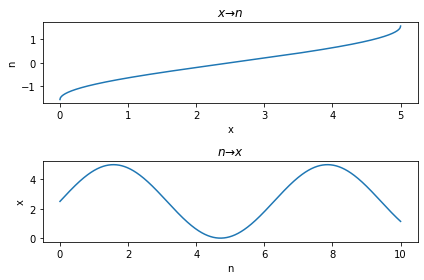

In [13]:
def plot_trfs():
    bounds = [0,5]

    f,axarr = plt.subplots(2,1)

    x = jnp.linspace(bounds[0],bounds[1],1001)
    n = jax.vmap(to_inf,in_axes=(0,None))(x,bounds)
    ax = axarr[0]
    ax.plot(x,n)
    ax.set_xlabel('x')
    ax.set_ylabel('n')
    ax.set_title(r'$x \to n$')

    n = jnp.linspace(0,10,1001)
    x = jax.vmap(to_bounded,in_axes=(0,None))(n,bounds)

    ax = axarr[1]
    ax.plot(n,x)
    ax.set_xlabel('n')
    ax.set_ylabel('x')
    ax.set_title(r'$n \to x$')
    f.set_tight_layout(True)
plot_trfs()

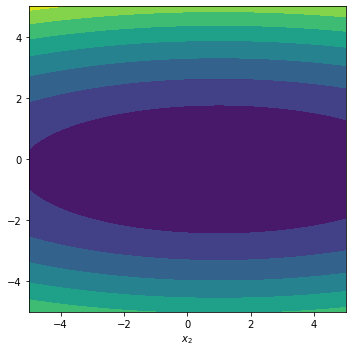

In [24]:
def func(external_pars):
    x,y = external_pars
    z = (x-1)**2 + (3*y+1)**2
    return z

def internal_func(internal_pars,bounds):
    external_pars = to_bounded(internal_pars,bounds)
    return func(external_pars)

def plot_external_func():
    grid = x,y = np.mgrid[-5:5:101j,-5:5:101j]
    X = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    Z = jax.vmap(func)(X)
    z = jnp.swapaxes(Z.reshape(101,101),0,-1)
    f,ax = plt.subplots(1,1)
    ax.contourf(x,y,z)
    f.set_tight_layout(True)
    ax.set_xlabel(r'$x_1$')
    ax.set_xlabel(r'$x_2$')
    f.set_size_inches(5,5)

def plot_internal_func():
    grid = x,y = np.mgrid[-5:5:101j,-5:5:101j]
    X = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    Z = jax.vmap(func)(X)
    z = jnp.swapaxes(Z.reshape(101,101),0,-1)
    f,ax = plt.subplots(1,1)
    ax.contourf(x,y,z)
    f.set_tight_layout(True)
    ax.set_xlabel(r'$x_1$')
    ax.set_xlabel(r'$x_2$')
    f.set_size_inches(5,5)

plot_external_func()

In [23]:
jax.

NameError: name 'X' is not defined